In [1]:
from pathlib import Path

import numpy as np
import pandas
from Bio import SeqIO
from matplotlib import pyplot
import seaborn


def get_hie(seq_index):
    hie = {}
    for name in seq_index:
        record = seq_index[name]
        sf = '.'.join(record.description.split()[1].split('.')[:3])
        hie.setdefault(sf, [])
        hie[sf].append(record)
    return hie


scop95_idx = SeqIO.index('data/scop/astral-scopedom-seqres-gd-sel-gs-bib-95-2.07.fa', 'fasta')
scop95_hie = get_hie(scop95_idx)
scop100_idx = SeqIO.index('data/scop/astral-scopedom-seqres-gd-all-2.07-stable.fa', 'fasta')
scop100_hie = get_hie(scop100_idx)
deltablast_d = np.load('data/delta_scop95.npy', allow_pickle=True).item()
test_data = get_hie(SeqIO.index('evaluation.fasta', 'fasta'))
candidates = pandas.read_csv('data/new_hits.csv')

In [2]:
from pathlib import Path
from tqdm.auto import tqdm
import pandas

from agora import TMalignCommandLine

new_hit_tmscore_d = {'Aligner': [], 'Query': [], 'Template': [], 'TM-score': [], 'PDB': []}

for r in tqdm(candidates.itertuples(), total=candidates.shape[0]):
    for pdb in list(Path('data/evaluation/delta_u50_50_u50_50_s95_500_evalue_sum_local/').glob(f'{r.Query}_*.pdb')):
            template = [_ for _ in pdb.read_text().splitlines() if _.startswith('REMARK') and 'TEMPLATE:' in _][0].split()[3]
            if template in r.new_hit:
                tmalign = TMalignCommandLine(f'data/evaluation/targets/{r.Query}.ent', pdb.as_posix())
                tmalign.run()
                if tmalign.tmscore is not None:
                    new_hit_tmscore_d['Aligner'].append('Baseline')
                    new_hit_tmscore_d['Query'].append(r.Query)
                    new_hit_tmscore_d['Template'].append(template)
                    new_hit_tmscore_d['TM-score'].append(tmalign.tmscore[0])
                    new_hit_tmscore_d['PDB'].append(pdb.stem)
                    
    for pdb in list(Path('data/evaluation/delta_u50_50_u50_50_s95_500_evalue_sum_local_i_local_p5p5p20/').glob(f'{r.Query}_*.pdb')):
        template = [_ for _ in pdb.read_text().splitlines() if _.startswith('REMARK') and 'TEMPLATE:' in _][0].split()[3]
        if template in r.new_hit:
            tmalign = TMalignCommandLine(f'data/evaluation/targets/{r.Query}.ent', pdb.as_posix())
            tmalign.run()
            if tmalign.tmscore is not None:
                new_hit_tmscore_d['Aligner'].append('Proposed A')
                new_hit_tmscore_d['Query'].append(r.Query)
                new_hit_tmscore_d['Template'].append(template)
                new_hit_tmscore_d['TM-score'].append(tmalign.tmscore[0])
                new_hit_tmscore_d['PDB'].append(pdb.stem)
                
    for pdb in list(Path('data/evaluation/delta_u50_50_u50_50_s95_500_evalue_sum_local_i_local_p5p5p20_skip_intermediates/').glob(f'{r.Query}_*.pdb')):
        template = [_ for _ in pdb.read_text().splitlines() if _.startswith('REMARK') and 'TEMPLATE:' in _][0].split()[3]
        if template in r.new_hit:
            tmalign = TMalignCommandLine(f'data/evaluation/targets/{r.Query}.ent', pdb.as_posix())
            tmalign.run()
            if tmalign.tmscore is not None:
                new_hit_tmscore_d['Aligner'].append('Proposed B')
                new_hit_tmscore_d['Query'].append(r.Query)
                new_hit_tmscore_d['Template'].append(template)
                new_hit_tmscore_d['TM-score'].append(tmalign.tmscore[0])
                new_hit_tmscore_d['PDB'].append(pdb.stem)

new_hit_tmscore_df = pandas.DataFrame.from_dict(new_hit_tmscore_d)
new_hit_tmscore_df

,Aligner,Query,Template,TM-score,PDB
0,Baseline,d2oi8a1,d1d5ya1,0.43479,d2oi8a1_60
1,Baseline,d2oi8a1,d1bl0a1,0.47732,d2oi8a1_61
2,Baseline,d2oi8a1,d1hlva1,0.38764,d2oi8a1_72
3,Baseline,d2oi8a1,d1bw6a_,0.40204,d2oi8a1_75
4,Baseline,d2oi8a1,d1lfup_,0.41631,d2oi8a1_93
...,...,...,...,...,...
946,Proposed B,d2c42a1,d2bfdb1,0.39143,d2c42a1_35
947,Proposed B,d2c42a1,d1umda_,0.30759,d2c42a1_42
948,Proposed B,d2c42a1,d2ji7a3,0.41462,d2c42a1_46
949,Proposed B,d2c42a1,d2ji7a2,0.57069,d2c42a1_7


In [3]:
sw = new_hit_tmscore_df[new_hit_tmscore_df['Aligner'] == 'Baseline']
isw = new_hit_tmscore_df[new_hit_tmscore_df['Aligner'] == 'Proposed A']
merged_df = pandas.merge(sw, isw, on='PDB')
merged_df['diff'] = merged_df['TM-score_y'] - merged_df['TM-score_x']
merged_df['Query'] = merged_df['PDB'].apply(lambda _: _[:7])
merged_df['Rank'] = merged_df['PDB'].apply(lambda _: int(_.split('_')[-1]))
merged_df = merged_df.sort_values('diff')
merged_df

,Aligner_x,Query_x,Template_x,TM-score_x,PDB,Aligner_y,Query_y,Template_y,TM-score_y,diff,Query,Rank
177,Baseline,d2pcsa1,d5i8fa1,0.55775,d2pcsa1_51,Proposed A,d2pcsa1,d5i8fa1,0.49845,-0.05930,d2pcsa1,51
2,Baseline,d2oi8a1,d1hlva1,0.38764,d2oi8a1_72,Proposed A,d2oi8a1,d1hlva1,0.36777,-0.01987,d2oi8a1,72
166,Baseline,d2pcsa1,d4a8ua_,0.52712,d2pcsa1_33,Proposed A,d2pcsa1,d4a8ua_,0.51210,-0.01502,d2pcsa1,33
163,Baseline,d2pcsa1,d1fm4a_,0.52898,d2pcsa1_27,Proposed A,d2pcsa1,d1fm4a_,0.51771,-0.01127,d2pcsa1,27
0,Baseline,d2oi8a1,d1d5ya1,0.43479,d2oi8a1_60,Proposed A,d2oi8a1,d1d5ya1,0.43479,0.00000,d2oi8a1,60
...,...,...,...,...,...,...,...,...,...,...,...,...
62,Baseline,d4a0yb_,d1vh5a1,0.40553,d4a0yb__27,Proposed A,d4a0yb_,d1vh5a1,0.77017,0.36464,d4a0yb_,27
173,Baseline,d2pcsa1,d3ijta1,0.18937,d2pcsa1_44,Proposed A,d2pcsa1,d3ijta1,0.59695,0.40758,d2pcsa1,44
57,Baseline,d4a0yb_,d3q62a1,0.13145,d4a0yb__14,Proposed A,d4a0yb_,d3q62a1,0.66140,0.52995,d4a0yb_,14
56,Baseline,d4a0yb_,d3r87a_,0.12813,d4a0yb__100,Proposed A,d4a0yb_,d3r87a_,0.66484,0.53671,d4a0yb_,100


In [5]:
merged_df.query('diff < 0')

,Aligner_x,Query_x,Template_x,TM-score_x,PDB,Aligner_y,Query_y,Template_y,TM-score_y,diff,Query,Rank
177,Baseline,d2pcsa1,d5i8fa1,0.55775,d2pcsa1_51,Proposed A,d2pcsa1,d5i8fa1,0.49845,-0.05930,d2pcsa1,51
2,Baseline,d2oi8a1,d1hlva1,0.38764,d2oi8a1_72,Proposed A,d2oi8a1,d1hlva1,0.36777,-0.01987,d2oi8a1,72
166,Baseline,d2pcsa1,d4a8ua_,0.52712,d2pcsa1_33,Proposed A,d2pcsa1,d4a8ua_,0.51210,-0.01502,d2pcsa1,33
163,Baseline,d2pcsa1,d1fm4a_,0.52898,d2pcsa1_27,Proposed A,d2pcsa1,d1fm4a_,0.51771,-0.01127,d2pcsa1,27


In [4]:
sw = new_hit_tmscore_df[new_hit_tmscore_df['Aligner'] == 'Proposed A']
isw = new_hit_tmscore_df[new_hit_tmscore_df['Aligner'] == 'Proposed B']
merged_df2 = pandas.merge(sw, isw, on='PDB')
merged_df2['diff'] = merged_df2['TM-score_y'] - merged_df['TM-score_x']
merged_df2['Query'] = merged_df2['PDB'].apply(lambda _: _[:7])
merged_df2['Rank'] = merged_df2['PDB'].apply(lambda _: int(_.split('_')[-1]))
merged_df2 = merged_df2.sort_values('diff')
merged_df2

,Aligner_x,Query_x,Template_x,TM-score_x,PDB,Aligner_y,Query_y,Template_y,TM-score_y,diff,Query,Rank
309,Proposed A,d2c42a1,d5vrba2,0.13437,d2c42a1_26,Proposed B,d2c42a1,d5vrba2,0.13437,-0.42962,d2c42a1,26
192,Proposed A,d1zuna1,d1wxia_,0.21852,d1zuna1_70,Proposed B,d1zuna1,d1wxia_,0.21852,-0.38091,d1zuna1,70
301,Proposed A,d2c42a1,d5nd6a2,0.20867,d2c42a1_15,Proposed B,d2c42a1,d5nd6a2,0.20867,-0.25433,d2c42a1,15
208,Proposed A,d4pc3c1,d1qzea2,0.33705,d4pc3c1_36,Proposed B,d4pc3c1,d1qzea2,0.33705,-0.25283,d4pc3c1,36
283,Proposed A,d1tdja2,d3c20a2,0.48775,d1tdja2_18,Proposed B,d1tdja2,d3c20a2,0.48775,-0.19484,d1tdja2,18
...,...,...,...,...,...,...,...,...,...,...,...,...
63,Proposed A,d4a0yb_,d4k4ca_,0.38542,d4a0yb__28,Proposed B,d4a0yb_,d4k4ca_,0.80770,0.42228,d4a0yb_,28
173,Proposed A,d2pcsa1,d3ijta1,0.59695,d2pcsa1_44,Proposed B,d2pcsa1,d3ijta1,0.64642,0.45705,d2pcsa1,44
57,Proposed A,d4a0yb_,d3q62a1,0.66140,d4a0yb__14,Proposed B,d4a0yb_,d3q62a1,0.66140,0.52995,d4a0yb_,14
56,Proposed A,d4a0yb_,d3r87a_,0.66484,d4a0yb__100,Proposed B,d4a0yb_,d3r87a_,0.66484,0.53671,d4a0yb_,100


In [6]:
merged_df2.query('diff < 0')

,Aligner_x,Query_x,Template_x,TM-score_x,PDB,Aligner_y,Query_y,Template_y,TM-score_y,diff,Query,Rank
309,Proposed A,d2c42a1,d5vrba2,0.13437,d2c42a1_26,Proposed B,d2c42a1,d5vrba2,0.13437,-0.42962,d2c42a1,26
192,Proposed A,d1zuna1,d1wxia_,0.21852,d1zuna1_70,Proposed B,d1zuna1,d1wxia_,0.21852,-0.38091,d1zuna1,70
301,Proposed A,d2c42a1,d5nd6a2,0.20867,d2c42a1_15,Proposed B,d2c42a1,d5nd6a2,0.20867,-0.25433,d2c42a1,15
208,Proposed A,d4pc3c1,d1qzea2,0.33705,d4pc3c1_36,Proposed B,d4pc3c1,d1qzea2,0.33705,-0.25283,d4pc3c1,36
283,Proposed A,d1tdja2,d3c20a2,0.48775,d1tdja2_18,Proposed B,d1tdja2,d3c20a2,0.48775,-0.19484,d1tdja2,18
...,...,...,...,...,...,...,...,...,...,...,...,...
217,Proposed A,d4pc3c1,d2cosa1,0.59616,d4pc3c1_98,Proposed B,d4pc3c1,d2cosa1,0.59616,-0.00632,d4pc3c1,98
199,Proposed A,d4pc3c1,d1veka1,0.60143,d4pc3c1_15,Proposed B,d4pc3c1,d1veka1,0.60143,-0.00613,d4pc3c1,15
189,Proposed A,d1zuna1,d2pz8a1,0.52638,d1zuna1_54,Proposed B,d1zuna1,d2pz8a1,0.52638,-0.00334,d1zuna1,54
195,Proposed A,d1ywfa1,d2nlka2,0.49735,d1ywfa1_75,Proposed B,d1ywfa1,d2nlka2,0.49735,-0.00211,d1ywfa1,75


In [6]:
from scipy import stats
display(stats.ttest_rel(merged_df['TM-score_x'], merged_df['TM-score_y']))
display(stats.ttest_rel(merged_df2['TM-score_x'], merged_df2['TM-score_y']))

Ttest_relResult(statistic=-7.505343146186368, pvalue=6.286265281919446e-13)

Ttest_relResult(statistic=-3.7537563295666576, pvalue=0.00020739801418026378)

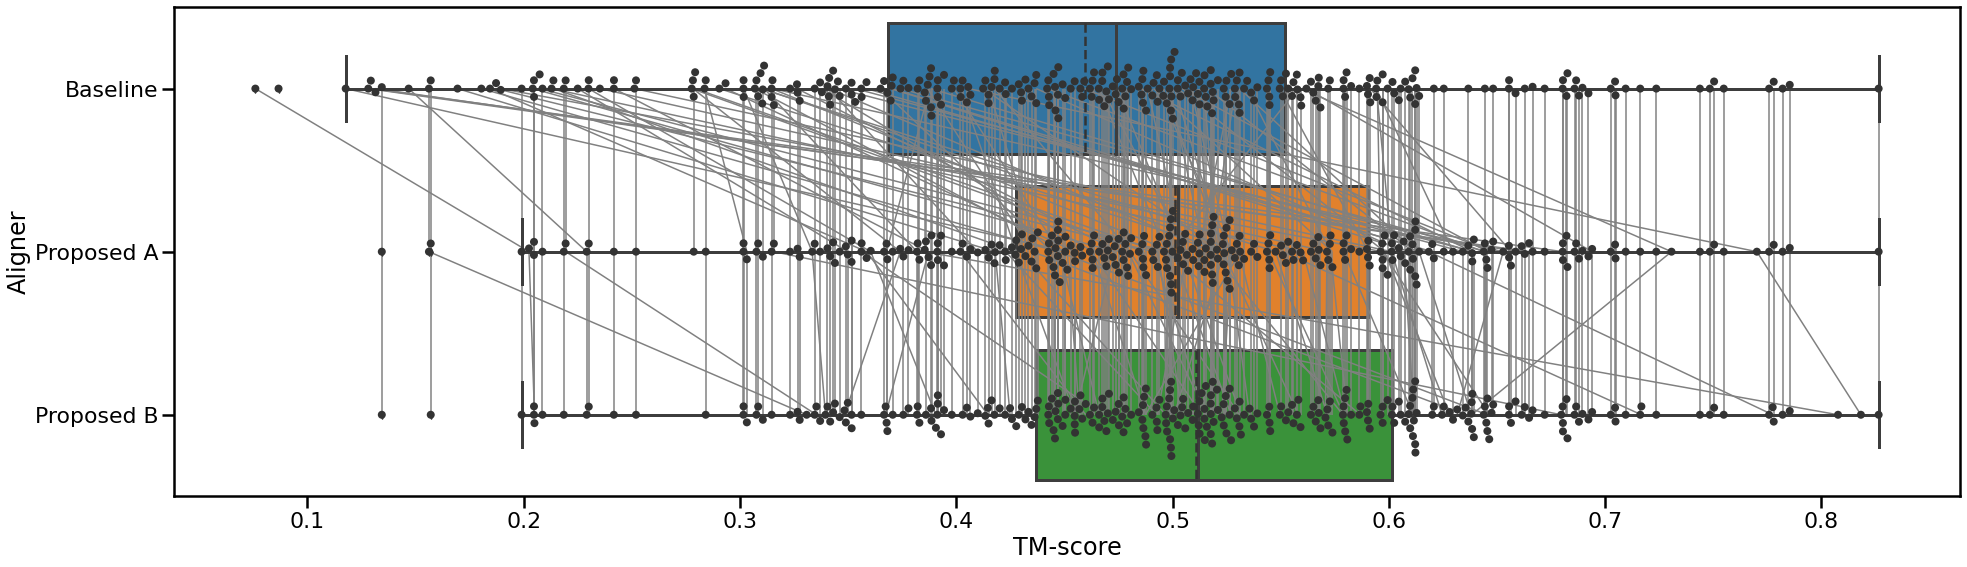

In [5]:
%matplotlib inline

from matplotlib import pyplot, collections
import seaborn

seaborn.set_context('poster')
fig, ax = pyplot.subplots(figsize=(32, 9))
seaborn.boxplot(x='TM-score', y='Aligner', data=new_hit_tmscore_df,
               showmeans=True, meanline=True, ax=ax, meanprops={'color': '#333333', 'linewidth': 2.5})
seaborn.swarmplot(x='TM-score', y='Aligner', data=new_hit_tmscore_df, color='0.2', size=8, ax=ax)
ax.add_collection(collections.LineCollection([[(_[1][3], 0), (_[1][8], 1)] for _ in merged_df.iterrows()], linewidths=1.5, colors='gray'))
ax.add_collection(collections.LineCollection([[(_[1][3], 1), (_[1][8], 2)] for _ in merged_df2.iterrows()], linewidths=1.5, colors='gray'))
fig.savefig('img/hard_tm_skip.pdf', bbox_inches='tight', pad_inches=0)